In [1]:
#fast ai

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
#import torch
#from torch import nn, optim
import seaborn as sns
from pathlib import Path
import PIL
import json
from fastai import *
from fastai.tabular import * 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
!ls "drive/My Drive/Colab Notebooks/Tabular/JanatahackAgriculture/inputs"

sample_submission.csv  test.csv  train.csv


In [275]:
# Read data
train = pd.read_csv('drive/My Drive/Colab Notebooks/Tabular/JanatahackAgriculture/inputs/train.csv')
test = pd.read_csv('drive/My Drive/Colab Notebooks/Tabular/JanatahackAgriculture/inputs/test.csv')
sample_sub  = pd.read_csv('drive/My Drive/Colab Notebooks/Tabular/JanatahackAgriculture/inputs/sample_submission.csv') 

In [276]:
#feature engineering and data prep

In [277]:
train.columns

Index(['ID', 'Estimated_Insects_Count', 'Crop_Type', 'Soil_Type',
       'Pesticide_Use_Category', 'Number_Doses_Week', 'Number_Weeks_Used',
       'Number_Weeks_Quit', 'Season', 'Crop_Damage'],
      dtype='object')

In [278]:
# ## Regularized Expanding mean scheme
# for features in ['Number_Doses_Week','Number_Weeks_Used','Number_Weeks_Quit']:
#     cumsum = train.groupby([features,'Crop_Damage']).cumcount()
#     #cumcnt = train.groupby(features).cumcount()  
    
#     train[features + 'meantarget'] = cumsum #/cumcnt
#     test[features + 'meantarget'] = cumsum #/cumcnt

In [279]:
drop_lst = ['ID']

In [280]:
len(train.columns),len(test.columns)

(10, 9)

In [281]:
train = train.drop(drop_lst,axis =1 )
test = test.drop(drop_lst,axis =1 )

In [282]:
train.columns

Index(['Estimated_Insects_Count', 'Crop_Type', 'Soil_Type',
       'Pesticide_Use_Category', 'Number_Doses_Week', 'Number_Weeks_Used',
       'Number_Weeks_Quit', 'Season', 'Crop_Damage'],
      dtype='object')

In [283]:
train.head()

,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage
0,188,1,0,1,0,0.0,0,1,0
1,209,1,0,1,0,0.0,0,2,1
2,257,1,0,1,0,0.0,0,2,1
3,257,1,1,1,0,0.0,0,2,1
4,342,1,0,1,0,0.0,0,2,1


In [284]:
procs = [FillMissing, Categorify, Normalize]

In [285]:
cat_vars = ['Crop_Type', 'Soil_Type', 'Pesticide_Use_Category', 'Season']
cont_vars = ['Estimated_Insects_Count',  'Number_Doses_Week', 'Number_Weeks_Used', 'Number_Weeks_Quit']

In [286]:
train[cat_vars] = train[cat_vars].astype('category')
test[cat_vars] = test[cat_vars].astype('category')

In [287]:
train.Crop_Damage.value_counts()

0    74238
1    12307
2     2313
Name: Crop_Damage, dtype: int64

In [288]:
dep_var = 'Crop_Damage'

In [289]:
path ='drive/My Drive/Colab Notebooks/Tabular/JanatahackAgriculture/inputs/'

In [290]:
data = (TabularList.from_df(train, cat_names=cat_vars, cont_names=cont_vars, procs=procs)
                .split_by_rand_pct(valid_pct=0.20)                
                .label_from_df(cols=dep_var)
                .add_test(TabularList.from_df(test, cat_names=cat_vars, cont_names=cont_vars),label=0)
                .databunch())

#TabularDataBunch.from_df(path, train, dep_var=dep_var, valid_idx=valid_idx, test_df=test)

In [291]:
data.show_batch(rows= 6)

Crop_Type,Soil_Type,Pesticide_Use_Category,Season,Number_Weeks_Used_na,Estimated_Insects_Count,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,target
1,1,3,2,False,-0.5697,2.1969,0.2090,-0.9703,0
1,0,3,2,False,-0.0161,-1.0194,-1.4127,-0.9703,0
1,0,2,2,False,-0.7864,-1.3410,-0.2178,-0.2643,0
1,0,2,1,False,-1.2057,0.5887,-0.9006,-0.3652,0
0,0,3,3,False,0.2089,2.1969,1.4039,-0.9703,1
0,1,2,1,False,1.1806,-0.3762,2.0867,-0.8695,0


In [292]:
learn = tabular_learner(data, layers=[500,300],metrics=accuracy,ps=[0.001,0.01], emb_drop=0.04,emb_szs={'Crop_Type': 4,'Soil_Type': 4})

In [293]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


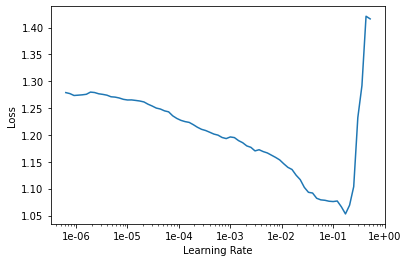

In [294]:
learn.recorder.plot()

In [295]:
#learn.fit(1, 1e-2)

In [296]:
lr = 1e-2
learn.fit_one_cycle(15, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.463948,0.468579,0.822239,00:16
1,0.461639,0.454819,0.836250,00:16
2,0.437067,0.445863,0.839626,00:16
3,0.447711,0.436527,0.839964,00:16
4,0.436867,0.433738,0.841033,00:16
5,0.448827,1.557783,0.833043,00:16
6,0.434402,0.439815,0.840696,00:16
7,0.430705,0.482391,0.842159,00:16
8,0.432382,0.453256,0.840527,00:16
9,0.437361,0.429364,0.843284,00:16


In [297]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.445533,0.430596,0.842890,00:16
1,0.433171,0.437528,0.838557,00:17
2,0.442541,0.455867,0.842721,00:17
3,0.419803,0.432069,0.842552,00:16
4,0.408182,0.426268,0.843790,00:16


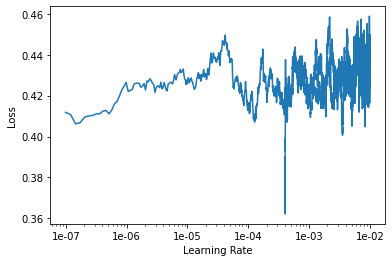

In [298]:
learn.recorder.plot()

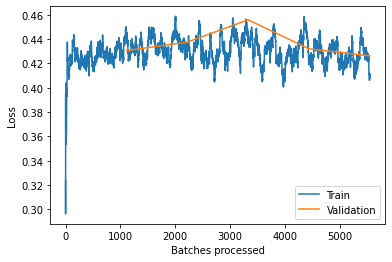

In [299]:
learn.recorder.plot_losses()

In [300]:
test_preds, targets = learn.get_preds(ds_type=DatasetType.Test)
predictions = np.argmax(test_preds, axis = 1) 
predictions

tensor([1, 1, 1,  ..., 0, 0, 0])

In [301]:
results = pd.DataFrame(data=predictions, columns=["Crop_Damage"])
#results['gender'] = results['gender'].map({1:'female',0:'male'})
sample_sub['Crop_Damage'] = results['Crop_Damage']
sample_sub.to_csv(path+'/sample_submission_26th_July_6.csv',index=False)

In [302]:
sample_sub.Crop_Damage.value_counts()

0    56999
1     2300
2       11
Name: Crop_Damage, dtype: int64

In [303]:
#finished
